In [164]:
# helper
from graphviz import Digraph

def _trace(root):
    nodes, edges = set(), []

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v.children:
                edges.append((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format="png", graph_attr={"rankdir": "LR"})
    nodes, edges = _trace(root)

    for n in nodes:
        uid = str(id(n))
        label = f"{n.data}"
        if n.operation:
            label += f" | {n.operation}"
        label += f" | ∇={n.grad}"
        dot.node(uid, label=label, shape="record")

    for src, dst in edges:
        dot.edge(str(id(src)), str(id(dst)))

    return dot

In [165]:
import numpy as np
from numbers import Real

class Value():
    def __init__(self, data, operation="", children=()):
        if isinstance(data, (list, tuple, Real)):
            data = np.array(data, dtype=float)
        assert isinstance(data, np.ndarray), "data must be a numpy array"
        self.data = data
        self.operation = operation
        self.children = children
        self.grad = np.zeros_like(self.data, dtype=float)
        self._backward = lambda: None

    def __repr__(self):
        return str(self.data)
    
    def dot(self, other):
        other = other if isinstance(other, Value) else Value(other)
        assert self.data.ndim == 1 and other.data.ndim == 1, "Dot product is only defined for vectors"
        result = Value(np.dot(self.data, other.data), "•", (self, other))
        def _backward():
            self.grad += np.dot(result.grad, other.data)
            other.grad += np.dot(result.grad, self.data)
        result._backward = _backward
        return result

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        result = Value(self.data + other.data, "+", (self, other))
        def _backward():
            self.grad += result.grad
            other.grad += result.grad
        result._backward = _backward
        return result

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        assert not self.data.shape or not other.data.shape, "Multiplication is undefined for two non-scalar values"
        result = Value(self.data * other.data, "*", (self, other))
        def _backward():
            self.grad += result.grad * other.data
            other.grad += result.grad * self.data
        result._backward = _backward
        return result
    
    def __pow__(self, other):
        assert isinstance(other, (float, int)), "power must be float or integer" # must force "other" to be primitive float or int
        assert other >= 0, "power must be non-negative"
        result = Value(self.data ** other, "^", (self,))
        def _backward():
            self.grad += other * self.data ** (other - 1) * result.grad
        result._backward = _backward
        return result
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + -other
    
    def __truediv__(self, other):
        return self * other ** -1
    
    def __radd__(self, other):
        return self + other
    
    def __rsub__(self, other):
        return self - other
    
    def __rmul__(self, other):
        return self * other
    
    def __rtruediv__(self, other):
        return self / other
    
    def backward(self):
        # A topological sort is a graph traversal in which each node v is visited only after all its dependencies are visited.
        # We need this, since we must call backward() on a child strictly after it has been called on its parent
        nodes = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v.children:
                    build_topo(child)
                nodes.append(v)
        build_topo(self)
        self.grad = np.ones(self.data.shape)
        for node in reversed(nodes):
            node._backward()

    def zero_grad(self):
        self.grad = np.zeros_like(self.data, dtype=float)
        for child in self.children:
            assert isinstance(child, Value), "Child must be an instance of Value"
            child.zero_grad()

    def relu(self):
        result = Value(np.maximum(0, self.data), "ReLU", (self,))
        def _backward():
            self.grad += (result.data > 0) * result.grad
        result._backward = _backward
        return result
    

In [166]:
a = Value(10)
b = Value(20)
c = Value(2)
d = a + b
e = d * c
loss = 0.2 * e

loss.backward()

$$ \frac{\mathrm{dL}}{\mathrm{dL}} = 1.0 $$
$$ \mathrm{L} = 0.2 \mathrm{e} \implies \frac{\mathrm{dL}}{\mathrm{de}} = 0.2 $$
$$ \mathrm{e} = \mathrm{d} \times \mathrm{c} \implies \frac{\mathrm{de}}{\mathrm{dd}} = \mathrm{c} \quad \frac{\mathrm{de}}{\mathrm{dc}} = \mathrm{d} $$
$$ \mathrm{d} = \mathrm{a} + \mathrm{b} \implies \frac{\mathrm{dd}}{\mathrm{da}} = 1 \quad \frac{\mathrm{dd}}{\mathrm{db}} = 1$$

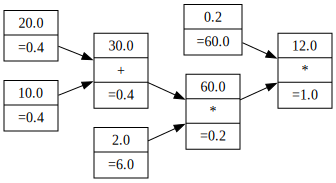

In [167]:
dot = draw_dot(loss)
dot

119.99469589159301 1.0
[ 9.43606798 11.73205081] [6.5 5. ]
[2.23606798 1.73205081] [6.5 5. ]
[5. 3.] [1.45344419 1.44337567]
[6.5 5. ] [ 9.43606798 11.73205081]
[ 7.2 10. ] [6.5 5. ]


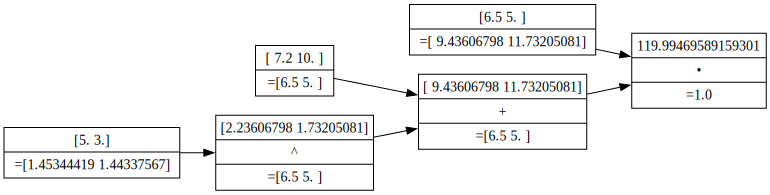

In [168]:
a = Value([5, 3])
b = Value([6.5, 5])
c = Value([7.2, 10])
d = a **0.5
e = d + c
loss = e.dot(b)

loss.backward()

print(loss.data, loss.grad)
print(e.data, e.grad)
print(d.data, d.grad)
print(a.data, a.grad)
print(b.data, b.grad)
print(c.data, c.grad)


dot = draw_dot(loss)
dot

In [169]:
import random

class Module:
    def zero_grad(self):
        for param in self.parameters():
            param.grad = np.zeros_like(param.data, dtype=float)

    def parameters(self):
        return []

class Neuron(Module):
    def __init__(self, num_in, nonlin=True):
        self.weights = [Value(random.uniform(-1, 1)) for _ in range(num_in)]
        self.bias = Value(0)
        self.nonlin = nonlin
    
    def __call__(self, x):
        x_data = x.data if isinstance(x, Value) else np.array(x)
        act = self.bias
        for wi, xi in zip(self.weights, x_data):
            act = act + wi * xi
        return act.relu() if self.nonlin else act
    
    def parameters(self):
        return self.weights + [self.bias]
    
    def __repr__(self):
        return f"Neuron(weights={self.weights}, bias={self.bias}, nonlin={self.nonlin})"

class Layer(Module):
    def __init__(self, num_in, num_out, **kwargs):
        self.neurons = [Neuron(num_in, **kwargs) for _ in range(num_out)]
    
    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out
    
    def parameters(self):
        return [param for neuron in self.neurons for param in neuron.parameters()]
    
    def __repr__(self):
        return f"Layer(neurons={self.neurons})"
    
class MLP(Module):
    def __init__(self, num_in, num_outs):
        sz = [num_in] + num_outs
        self.layers = [Layer(sz[i], sz[i + 1], nonlin=i!=len(num_outs)-1) for i in range(len(num_outs))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [param for layer in self.layers for param in layer.parameters()]
    
    def __repr__(self):
        return f"MLP(layers={self.layers})"

In [170]:
model = MLP(2, [3, 1])

x = Value([1, 2])
y = Value(0)

In [171]:
for i in range(200):
    pred = model(x)
    print(pred)
    loss = (pred - y) ** 2
    loss.backward()
    for param in model.parameters():
        param.data -= 0.01 * param.grad  # Simple gradient descent step
    model.zero_grad()


1.095627667165272
0.9055858502321046
0.7577521924439323
0.6395170835160002
0.5430749043114931
0.4632760394440949
0.3965469802742045
0.34030389813887285
0.29261434223971605
0.25199220762553465
0.21726817817120425
0.18750482219580267
0.16193910180779214
0.13994226452290326
0.1209910804545461
0.1046466852881568
0.09053865180511922
0.07835274300666217
0.06782131785762147
0.05871569066112048
0.0508399593966401
0.04402596010105542
0.038129099781820774
0.03302488569609108
0.028606014368796395
0.024779916021298032
0.02146667339842323
0.01859725111306898
0.016111984435429494
0.013959286191948306
0.012094537962514362
0.010479137664204385
0.009079680300004833
0.007867252425434401
0.006816823956763418
0.005906723466593489
0.0051181852009662965
0.004434957793672978
0.0038429661143111193
0.0033300189182938755
0.0028855560098607347
0.0025004295152437628
0.002166714618355825
0.0018775457566333476
0.0016269748271720008
0.0014098484272053735
0.0012217015601120318
0.001058665588314578
0.00091738851599154